# Experiments 6. Rosenbrock Function

We will minimize

$$f(x_1, x_2) = 100(x_2-x_1^2)^2 + (x_1-1)^2.$$


In [1]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import timeit
from jax.config import config

In [2]:
from methods import gradf_inexact
from methods import GradientDescent, parse_logs, AdaptiveL, StepSize, AdaptiveNoiseGD
from methods import ConstantStepSize, AdaptiveLdelta

In [3]:
matplotlib.use('Agg')
params = {'legend.fontsize': 20,
          'legend.handlelength': 4,
          "axes.labelsize": 45,
          "xtick.labelsize": 25,
          "ytick.labelsize": 25,
          "lines.linewidth": 2,
           "axes.titlesize":30}
matplotlib.rcParams.update(params)

In [4]:
config.update("jax_enable_x64", True)

In [5]:
path_pics = "../pics/"

In [6]:
def f1(w1, w2):
    G = 100*(w2-w1**2)**2 + (w1-1)**2
    return G.sum()
gradf = jax.grad(f1, argnums=(0, 1), has_aux=False)
jit_gradf = jax.jit(gradf)

## 0. Dataset

In [7]:
sigma=0
n = 1
def gradf(x):
    z = jit_gradf(x[:n], x[n:])
    g = np.hstack([np.array(i.block_until_ready()) for i in z])
    return g
f2 = lambda x: f1(x[:n], x[n:])
gradf(np.array([1., 1.])), f2(np.array([1., 1.]))

(array([0., 0.]), 0.0)

## 1. Noise Distributed on the Unit Sphere

The case when $\xi \sim \mathcal{U}(S_1(0))$

$$\begin{bmatrix}400x_1^2 + 100& 20x_1\\ 20x_1& 1\end{bmatrix}$$

In [25]:
eps_list = [1e-8, 1e-6, 1e-4]

n = 1
dtype_list = [1, 3, 4]

w = np.ones(2*n)*2
w = np.array([1., 2.])
v = np.random.randn(2*n)
v = np.array([1., 0.])
res = {d:{"delta":[], 
           "iters_adaptL":[], "time_adaptL":[], "adaptL,x0-x*": [], "normg_adaptL": [],
           "iters_exact":[], "time_exact":[], "exact,x0-x*": [], "normg_exact": [], "residual_adaptL":[],
          "iters_adaptLdelta":[], "time_adaptLdelta":[], "adaptLdelta,x0-x*": [], "normg_adaptLdelta": []} for d in dtype_list}
mu_list = {}
number = 10
save_iter = 1
N = 10000
methods = []
np.random.seed(1)
print(np.linalg.norm(w-np.array([1, 1])))
for d in dtype_list:
    print(d)
    for eps in eps_list:
        mu = 1e-6
        Delta = np.sqrt(eps)
        f = lambda x: f2(x) + eps * np.random.uniform(-1, 1)
        res[d]["delta"].append(int(np.log10(Delta)))
        tol = 2*Delta


        grad_inexact = lambda w: gradf_inexact(w, gradf, Delta, d, v=v)
        print(eps)
        method = GradientDescent(AdaptiveL(L0=1, Delta=Delta, Lmin=mu/4, delta=eps), name="GD, Delta={}".format(Delta), save_iter=save_iter)
        x = method.solve(w, f, grad_inexact, tol=tol, max_iter=N)
        g = lambda: GradientDescent(AdaptiveL(L0=1, Delta=Delta, Lmin=mu/4),
                                    return_history=False).solve(w, f, grad_inexact, tol=tol, max_iter=N)
        T = timeit.timeit(g, number=number)/number        
        print("\t{}\t{}\t{:.2f}\t{:.6f}\t{:.2f}\t{}".format(Delta, len(method.history), T*1000, np.linalg.norm(x-w), 
                                                np.linalg.norm(gradf(x))/Delta, f2(x)))
        methods.append(method)
        res[d]["iters_adaptL"].append(len(method.history))
        res[d]["time_adaptL"].append("{:.2f}".format(T*1000))
        res[d]["adaptL,x0-x*"].append("{:.3f}".format(np.linalg.norm(x-w)))
        res[d]["normg_adaptL"].append("{:.2f}".format(np.linalg.norm(gradf(x))/Delta))
        res[d]["residual_adaptL"].append(f2(x))


#         method = AdaptiveNoiseGD(AdaptiveLdelta(L0=1, mindelta=1e-12, Lmin=mu/4, mu=mu, delta_alpha=2.1), name="GD, Delta={}".format(Delta), save_iter=save_iter, alpha=np.sqrt(6))
#         x = method.solve(w, f, grad_inexact, max_iter=N)
#         g = lambda: AdaptiveNoiseGD(AdaptiveLdelta(L0=1, mindelta=1e-12, Lmin=mu/4, mu=mu), return_history=False, 
#                                     alpha=np.sqrt(6)).solve(w, f, grad_inexact, max_iter=N)
#         T = timeit.timeit(g, number=number)/number        
#         print("\t{}\t{}\t{:.2f}\t{:.6f}\t{:.2f}\t{}".format(Delta, len(method.history), T*1000, np.linalg.norm(x-w), 
#                                                 np.linalg.norm(gradf(x))/Delta, f(x)))
#         methods.append(method)
#         res[d]["iters_adaptLdelta"].append(len(method.history))
#         res[d]["time_adaptLdelta"].append("{:.2f}".format(T*1000))
#         res[d]["adaptLdelta,x0-x*"].append("{:.3f}".format(np.linalg.norm(x-w)))
#         res[d]["normg_adaptLdelta"].append("{:.2f}".format(np.linalg.norm(gradf(x))/Delta))     
        print("\n")
    print("\n\n")


1.0
1
1e-08
	0.0001	7266	2273.26	0.999401	2.70	8.932739872386502e-08


1e-06
	0.001	5412	2594.61	0.993672	2.90	9.971167963631686e-06


0.0001
	0.01	3690	3163.32	0.939691	2.61	0.0008946273125060978





3
1e-08
	0.0001	7188	2615.61	0.999348	2.99	1.0607687717040395e-07


1e-06
	0.001	5493	2490.56	0.993467	3.00	1.0627427748525307e-05


0.0001
	0.01	3536	3031.05	0.930571	2.99	0.0011833792404510569





4
1e-08
	0.0001	7491	2301.32	0.999672	1.54	2.6800439879705168e-08


1e-06
	0.001	5697	2490.32	0.996908	1.87	2.3825303215698196e-06


0.0001
	0.01	3965	3485.89	0.965341	1.93	0.000297111879670701







In [26]:
s = ""

for d in dtype_list:
    s += str(d) + " & "

    cur_list = ["$10^{{{}}}$".format(i) for i in res[d]["delta"]]
    s+= "\\begin{tabular}{@{}c@{}} " + " \\\\ ".join(cur_list) + " \\end{tabular}&"

    cur_list = ["${}$".format(i) for i in res[d]["iters_adaptL"]]
    s+= "\\begin{tabular}{@{}c@{}} " + " \\\\ ".join(cur_list) + " \\end{tabular}&"
    cur_list = ["${}$".format(i) for i in res[d]["time_adaptL"]]
    s+= "\\begin{tabular}{@{}c@{}} " + " \\\\ ".join(cur_list) + " \\end{tabular}&"
    
    cur_list = ["${}$".format(i) for i in res[d]["adaptL,x0-x*"]]
    s+= "\\begin{tabular}{@{}c@{}} " + " \\\\ ".join(cur_list) + " \\end{tabular}&"
    cur_list = ["${}$".format(i) for i in res[d]["normg_adaptL"]]
    s+= "\\begin{tabular}{@{}c@{}} " + " \\\\ ".join(cur_list) + " \\end{tabular}&"
    
    cur_list1 = [(i/10**(int(np.log10(i))), int(np.log10(i))) for i in res[d]["residual_adaptL"]]
    cur_list = []
    for a, b in cur_list1:
        if b != 0:
            cur_list.append("${:.2f} \\cdot 10^{{{}}}$".format(a, b))
        else:
            cur_list.append("${:.2f}$".format(a))
    s+= "\\begin{tabular}{@{}c@{}} " + " \\\\ ".join(cur_list) + " \\end{tabular}"

    s+= "\\\\\n\\hline\n"
print(s)

1 & \begin{tabular}{@{}c@{}} $10^{-4}$ \\ $10^{-3}$ \\ $10^{-2}$ \end{tabular}&\begin{tabular}{@{}c@{}} $7266$ \\ $5412$ \\ $3690$ \end{tabular}&\begin{tabular}{@{}c@{}} $2273.26$ \\ $2594.61$ \\ $3163.32$ \end{tabular}&\begin{tabular}{@{}c@{}} $0.999$ \\ $0.994$ \\ $0.940$ \end{tabular}&\begin{tabular}{@{}c@{}} $2.70$ \\ $2.90$ \\ $2.61$ \end{tabular}&\begin{tabular}{@{}c@{}} $0.89 \cdot 10^{-7}$ \\ $1.00 \cdot 10^{-5}$ \\ $0.89 \cdot 10^{-3}$ \end{tabular}\\
\hline
3 & \begin{tabular}{@{}c@{}} $10^{-4}$ \\ $10^{-3}$ \\ $10^{-2}$ \end{tabular}&\begin{tabular}{@{}c@{}} $7188$ \\ $5493$ \\ $3536$ \end{tabular}&\begin{tabular}{@{}c@{}} $2615.61$ \\ $2490.56$ \\ $3031.05$ \end{tabular}&\begin{tabular}{@{}c@{}} $0.999$ \\ $0.993$ \\ $0.931$ \end{tabular}&\begin{tabular}{@{}c@{}} $2.99$ \\ $3.00$ \\ $2.99$ \end{tabular}&\begin{tabular}{@{}c@{}} $0.11 \cdot 10^{-6}$ \\ $0.11 \cdot 10^{-4}$ \\ $0.12 \cdot 10^{-2}$ \end{tabular}\\
\hline
4 & \begin{tabular}{@{}c@{}} $10^{-4}$ \\ $10^{-3}$ \\ $

# Visualization

In [8]:
def gradf_inexact(w, gradf, Delta=0, dtype=1, v=None):
    n = len(w)
    g = gradf(w)
    xi = np.random.normal(0, 1, (n,))
    if dtype == 1:
        xi /= np.linalg.norm(xi)
    elif dtype == 2:
        xi /= n
    elif dtype == 3:
        xi = -g.copy()
        xi /= np.linalg.norm(xi)
    elif dtype == 4:
        xi = v / np.linalg.norm(v)
    assert np.linalg.norm(xi) <= 1 + 1e-9, "xi has no 1 norm"
    return g + Delta * xi

In [16]:
np.random.seed(1)
methods = []
v = np.array([1., 0.])
w = np.array([2, 1.])

N = 15000

eps = 1e-2
Delta = 1e-1
tol = 2*Delta
save_iter = 1


mu = 1e-6

eps, Delta = 0, 0
f = lambda x: f2(x) + eps * np.random.uniform(-1, 1)
grad_inexact = lambda w: gradf_inexact(w, gradf, Delta, 1, v=v)
method = GradientDescent(AdaptiveL(L0=1, Delta=Delta, Lmin=mu/4, delta=eps), name="GD, Delta={}".format(Delta), save_iter=save_iter)
x = method.solve(w, f, grad_inexact, tol=tol, max_iter=N)
Delta = 1e-1
print(np.linalg.norm(gradf(x))/Delta, f(x), len(method.history))
methods.append(method)
    

    
eps = 0.01
Delta = 3
grad_name = {1:"random inexactness",3:"-gradient",4:"constant inexactness",}
N = 100000
#for dtype in [1]:
for dtype in [3]:
    mu = 1e-6
    Delta = np.sqrt(eps)
    print(Delta, eps)
    f = lambda x: f2(x) + eps * np.random.uniform(-1, 1)
    tol = 0
    grad_inexact = lambda w: gradf_inexact(w, gradf, Delta, dtype, v=v)
    print(grad_inexact(x), gradf(x))
    method = GradientDescent(AdaptiveL(L0=1, Delta=Delta, Lmin=mu/4, delta=eps), name="{}".format(grad_name[dtype]), save_iter=save_iter)
    x = method.solve(w, f, grad_inexact, tol=tol, max_iter=N)
    print(x)
    print(100*(x[1]-x[0]**2)**2+(x[0]-1)**2)
    print(f2(x))
    print(dtype, np.linalg.norm(gradf(x))/Delta, f2(x), len(method.history), np.linalg.norm(x-w))
    methods.append(method)

1.6311076134571192 0.014371785674047125 10
0.1 0.01
[0.06155362 0.01393271] [0.1590863  0.03600932]
[1.02716753 1.04926767]
0.0041084041564965375
0.0041084041564965375
3 27.01814653240872 0.0041084041564965375 100002


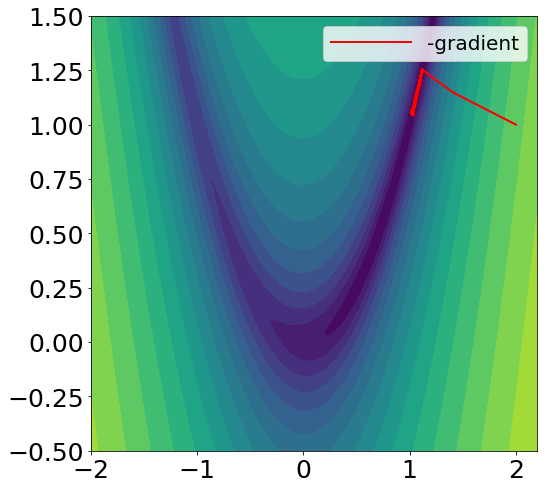

In [18]:
%matplotlib inline
l = 240
k = 100
x, y = np.mgrid[-l:l,
                -l:l]
x = x / k
y = y/k
z = np.zeros((2*l, 2*l))
f = lambda x: f2(x)


for i in range(2*l):
    for j in range(2*l):
        z[i, j] = f(np.array([x[i, j], y[i, j]]))
z = (np.log(z+1)+1)
fig, ax = plt.subplots()
ax.contourf(x, y, z, levels=20)

color = ["r", "y", "green", "b"]
for indm, method in enumerate(methods[1:]):
    xhistory = method.history
    x_list = np.array([x for x, _ in xhistory])
    plt.plot(x_list[:, 0], x_list[:, 1], color=color[indm], label=method.name)
    for ind in range(0, len(x_list)-1, 50):
        x, y = x_list[ind, 0], x_list[ind,1]
        dx, dy = x_list[ind+1, 0] - x_list[ind, 0], x_list[ind+1,1] - x_list[ind,1]
        head_width=0.01
        ax.arrow(x, y, dx, dy, color=color[indm], head_width=head_width)
plt.legend()

fig.set_figwidth(8)    #  ширина и
fig.set_figheight(8)    #  высота "Figure"

plt.xlim(-2, 2.2)
plt.ylim(-0.5, 1.5)
plt.savefig(os.path.join(path_pics, "lines_rosenbrock.png"))

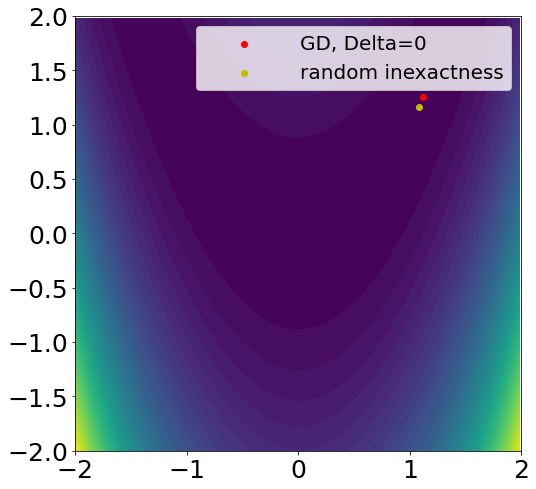

In [39]:
%matplotlib inline
l = 100
x, y = np.mgrid[-l:l,
                -l:l]
x = x / 50
y = y/50
z = np.zeros((2*l, 2*l))
f = lambda x: f2(x)

for i in range(2*100):
    for j in range(2*100):
        z[i, j] = f(np.array([x[i, j], y[i, j]]))
#z = np.log(z+1e-16)+16
fig, ax = plt.subplots()
ax.contourf(x, y, z, levels=50)


color = ["r", "y", "green", "b"]
for indm, method in enumerate(methods):
    xhistory = method.history
    x_list = np.array([x for x, _ in xhistory])
    plt.scatter([x_list[-1, 0]], [x_list[-1, 1]], color=color[indm], label=method.name)
plt.legend()

fig.set_figwidth(8)    #  ширина и
fig.set_figheight(8)    #  высота "Figure"

plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.savefig(os.path.join(path_pics, "lines_rosenbrock.png"))